# Notebook for extracting features for authorship attribution.
In this notebook all authorship attribution features will be collected. They will be saved after extraction. Make sure, you define each feature extraction in a function, so it easily can be repurposed.

Author: lkt259@alumni.ku.dk & vsl133@alumni.ku.dk

In [29]:
import numpy as np
import pandas as pd
import re
import time
from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
from lexicalrichness import LexicalRichness
from matplotlib import pyplot as plt
import random
import spacy
import scipy
import pickle
import os, sys

In [30]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

#### Sentence length
Nice feature, very complex!

In [31]:
string = "We can work with single sentences (classifying them with respect to sentiment, topic, authorship, etc), or more than one at a time (checking for similarities, contradiction, question/answer pairs, etc.) Another successful application is to encode one sentence in one language and use a different autoencoder to decode it into another language, e.g. Cho et al. (2014)."
train_corpus = ['This list has overlapping features with content features. For example, word n-grams will capture the content of the text along with stylometric tendencies. Content features consist of word frequencies, word and character n-grams, hapax legomena etc. This overlap is not of concern, however, as Sari et al. \cite{Sari2018} show, using content features is beneficial when performing authorship attribution of news articles because journalists often have certain topics they prefer writing about. They argue that using only stylometric features is beneficial when attributing authors to texts of the same topic or genre, e.g. law text or movie reviews.',
              'Bozkurt et al. \cite{Bozkurt} performed authorship attribution on Turkish newspaper articles using stylometric features, vocabulary diversity, bag of words and frequency of function words. For stylometric features, they used number of sentences and words in the article, the average number of words in a sentence and the whole article, the vocabulary size, frequencies of symbols used (periods, exclamation marks, etc.) and the number of incomplete sentences. They weighted their features using Term Frequency-Inverse Document Frequency (TF-IDF).',
              'TF-IDF is a weighting system often used on words. It consists of two parts: term frequency (TF), which coulds how often a term occurs in a document, and inverse document frequency (IDF) which measures the term importance, as it compares how often the term occurs in a corpus\cite{TFIDF}. The system is useful for measuring how important a term is for a document. For example, the word "the" will often occur in English texts, making it not important even though it occurs frequently in a document. TF-IDF has on many occasions been used in authorship attribution\cite{Muttenhaler, basile:2019, rahgouy:2019} and can be used on different terms, such as characters, symbols or n-grams.',
              'Every year, the research group Webis hosts the PAN shared tasks on digital text forensics and sylometry\cite{PAN}. Contestants will solve various tasks concerning NLP and on multiple occasions, authorship attribution were part of the tasks. The methodologies used in these tasks are useful resources for feature and model selections.',
              'In the overview paper of the authorship attribution task of PAN 2019\cite{kestemont2019overview}, the 12 best performing models are compiled. All features involve character n-grams and other sorts of n-grams. Other popular choices of n-grams contain words, POS tags, punctuation and distortion. Most of the participants use TF-IDF weighting and SVMs as classifiers. Distortion is a method for masking topical contents of the text before feature extraction, focusing only on stylometric features.']
test_corpus = ['I have been unable to generate numbers by the Bohr hypothesis, but given more time, I would have simulated multiple distributions following the formula and compare the peak locations to my fit results, by looking at their means and if plausible, perform a t- or z-test to compare. Perhaps using a Kolmogorov-Smirnov test on the entirety of the data would show if it matches only by the peaks or by the whole distribution.',
               "In recent years there have been an increasing interest in biometric identification. Various studies has been conducted aiming to detect individual or unique demographic traits. Results from recent studies have given reason to believe that the ability to predict demographic information using eye tracking is highly dependent on the stimulus. Based on this, this study performs a comparison using two datasets built on different stimulus: IQ tests and passive image viewing. This study found significant differences in the accuracy achieved on the two datasets using a Random Forest (RF) and Long-Short Term Memory network (LSTM) as classifiers. The random forest performed best with an accuracy of 0.85 on the passive image viewing dataset and 0.70 on the IQ dataset. Furthermore, we investigated the effect of using micro movements of the eye as features in the model, which has proven to be a useful feature in recent studies within biometric identification. Lastly, we report the classifiers' ability to perform task independent predictions of gender, using one dataset for training and another for testing. The result from this experiments was not satisfying and close to chance level. However, combining the dataset for training and testing resulted in the random forest having an overall accuracy on the combined dataset of 0.74.",
              ]

In [32]:
def split_sentences(text):
    '''Returns an array with text split into sentences'''
    return np.array(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text), dtype=str)

def remove_dots(word):
    return re.sub(r',|\.|:|!|\?|;', '', word)

def split_words(text):
    '''Returns an array with text split into words'''
    text = text.lower()
    string = np.array(text.split(), dtype=str)
    no_dot = np.array([remove_dots(x) for x in string])
    return np.array(list(filter(None, no_dot)))

def get_sentence_lengths(text):
    '''Returns dictionary with sentence lengh in chars and words'''
    split_text = split_sentences(text)
    num_sentences = len(split_text)
    num_chars = np.array([len(x) for x in split_text], dtype=int)
    num_words = [split_words(x).size for x in split_sentences(string)]
    return {'chars' : num_chars, 'words' : num_words, 'num_sents' : num_sentences}

def get_sentence_length_stats(text):
    '''Returns dictionary with mean, std and median lengths in both chars and words'''
    sentence_lengths = get_sentence_lengths(text)
    output = {'number_of_sentences' : sentence_lengths['num_sents'],
              'avg_sent_len_chars' : np.mean(sentence_lengths['chars']),
              'std_sent_len_chars' : np.std(sentence_lengths['chars']),
              'med_sent_len_chars' : np.median(sentence_lengths['chars']),
              
              'avg_sent_len_words' : np.mean(sentence_lengths['words']),
              'std_sent_len_words' : np.std(sentence_lengths['words']),
              'med_sent_len_words' : np.median(sentence_lengths['words'])
             }
    return output

print("Stats for our test document")
get_sentence_length_stats(string)

Stats for our test document


{'number_of_sentences': 2,
 'avg_sent_len_chars': 183.0,
 'std_sent_len_chars': 176.0,
 'med_sent_len_chars': 183.0,
 'avg_sent_len_words': 28.0,
 'std_sent_len_words': 27.0,
 'med_sent_len_words': 28.0}

##### Word length
The count of words of the entire text.
Also extremely complex feature, cool shit.

In [33]:
def get_word_lengths(split_text):
    '''Returns length of words in characters'''
    return np.array([len(x) for x in split_text], dtype=int)

def get_word_length_stats(text):
    '''Returns various stats for words in document'''
    #Split text here, to reduce function calls.
    split_text = split_words(text)
    word_lengths = get_word_lengths(split_text)
    output = {
        'number_of_words' : len(split_text),
        'avg_word_len_chars' : np.mean(word_lengths),
        'std_word_len_chars' : np.std(word_lengths),
        'med_word_len_chars' : np.median(word_lengths)
    }
    return output

print("Test word lengths")
get_word_length_stats(string)

Test word lengths


{'number_of_words': 56,
 'avg_word_len_chars': 5.339285714285714,
 'std_word_len_chars': 3.4500351225659682,
 'med_word_len_chars': 4.0}

### Word frequency
Get word frequencies with TF-IDF weightings.

Word frequency is the same as word unigrams - defined later.

In [34]:
def get_tfidf_names(vectorizer, X, h=5):
    ngrams = vectorizer.get_feature_names_out()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=ngrams)
    display(df.head(h))

### Hapax legomena
Count how many unique words are in a document.

In [35]:
def get_num_hapax(split_text):
    '''Returns the numer of hapax legomena, takes a split words as input'''
    fdist = nltk.probability.FreqDist(split_text)
    return len(fdist.hapaxes())

### Lexical diversity
Compute single-values describing the lexical diversities.

In [36]:
def compute_lix(text):
    tokens = nltk.word_tokenize(text)
    splt = text.split()
    o = len(splt)+1
    p = len([x for x in tokens if x=='.'])+1
    l = len([x for x in tokens if len(x)>6])+1
    
    return (o/p)+((l*100)/o)

def lexical_diversities(text):
    '''Returns a dictionary with various vocabulary richness measures'''
    lex = LexicalRichness(text, tokenizer=split_words)
    try:
        dugast = lex.Dugast
    except:
        dugast = 0
    
    try:
        herdan = lex.Herdan
    except:
        herdan = 0
    
    try:
        summer = lex.Summer
    except:
        summer = 0
    
    try:
        maas = lex.Maas
    except:
        maas = 0
    
    try:
        ttr = lex.ttr
    except:
        ttr = 0
    
    try:
        rttr = lex.rttr
    except:
        rttr = 0
    
    try:
        cttr = lex.cttr
    except:
        cttr = 0
        
    output = {
        'ttr' : ttr,
        'rttr' : rttr,
        'cttr' : cttr,
        'herdan' : herdan,
        'summer' : summer,
        'dugast' : dugast,
        'maas' : maas,
        'lix' : compute_lix(text)
    }
    return output

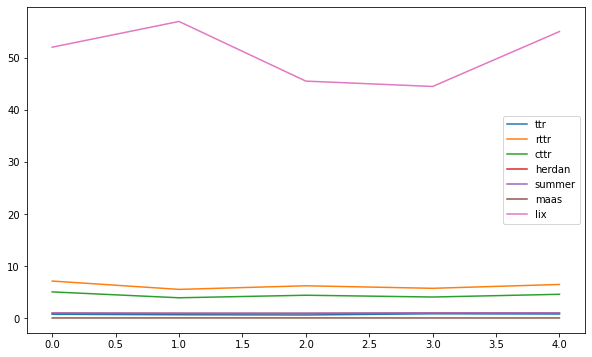

In [37]:
stats = [lexical_diversities(x) for x in train_corpus]

ttr = [x['ttr'] for x in stats]
rttr = [x['rttr'] for x in stats]
cttr = [x['cttr'] for x in stats]
herdan = [x['herdan'] for x in stats]
summer = [x['summer'] for x in stats]
maas = [x['maas'] for x in stats]
lix = [x['lix'] for x in stats]

fig = plt.figure(figsize=(10,6))
plt.plot(ttr, label='ttr')
plt.plot(rttr, label='rttr')
plt.plot(cttr, label='cttr')
plt.plot(herdan, label='herdan')
plt.plot(summer, label='summer')
plt.plot(maas, label='maas')
plt.plot(lix, label='lix')
plt.legend()

# LDA Topic
Generate topics using LDA

In [38]:
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaModel

with open('function_words/clean_function_words.txt', 'r', encoding='utf-8') as f:
    func_words = f.readlines()
    func_words = [x.replace('\n','') for x in func_words]

def remove_symbols(text):
    return re.sub('\W+',' ', text)

In [39]:
def tokenize_docs_for_lda(corpus, verbose=True):
    if verbose:
        docs = [remove_symbols(x) for x in tqdm(corpus)] # Remove symbols
        docs = [split_words(x.lower().strip()) for x in tqdm(docs)] #Word tokenize all text
        docs = [[token for token in doc if not token.isnumeric()] for doc in tqdm(docs)] #Remove numbers
        docs = [[token for token in doc if len(token)>1] for doc in tqdm(docs)] #Remove words of 1 character
        docs = [[token for token in doc if token not in func_words] for doc in tqdm(docs)] #Filter stop words
    else:
        docs = [remove_symbols(x) for x in corpus] # Remove symbols
        docs = [split_words(x.lower().strip()) for x in docs] #Word tokenize all text
        docs = [[token for token in doc if not token.isnumeric()] for doc in docs] #Remove numbers
        docs = [[token for token in doc if len(token)>1] for doc in docs] #Remove words of 1 character
        docs = [[token for token in doc if token not in func_words] for doc in docs] #Filter stop words
    return docs

In [40]:
import time

def create_lda_dictionary(docs):
    dictionary = Dictionary(docs)
    #Remove words that occur in less than 20 documents and more than 10% of all documents
    dictionary.filter_extremes(no_below=20, no_above=0.1)
    print("Creating dictionary...")
    corpus = [dictionary.doc2bow(doc) for doc in tqdm(docs)]
    print("Number of unique tokens:", len(dictionary))
    print("Number of documents:", len(corpus))
    return dictionary, corpus

def create_lda_model(docs, num_topics, epochs, save=False, load_path=None, verbose=False):
    '''Returns LDA model and dictionary'''
        
    #Get data (only for file name if saved)
    date = [x for x in time.localtime()]
    date = str(date[2])+'/'+str(date[1])+'/'+str(date[0])

    
    #Tokenize corpus, if raw text is given.
    if type(docs[0]) == str:
        print("You provided raw text. Tokenizing first...")
        docs = tokenize_docs_for_lda(docs, verbose=verbose)
        print("Tokenized!")
    
    #Create dictionary
    dictionary, corpus = create_lda_dictionary(docs)
    assert len(dictionary) > 0, "Oh no! No unique words... You need more text!"
    
    if load_path:
        print("Loading LDA model", load_path)
        return models.ldamodel.LdaModel.load(load_path), dictionary
    
    num_topics = num_topics
    chunksize = 2000 #2k
    passes = epochs #(epochs)
    iterations = 300 #400
    eval_every = 2
    
    _ = dictionary[0] #Initializes some values, necessary for model...
    id2word = dictionary.id2token
    model_name = "LDA"+date
    model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    chunksize=chunksize,
                    alpha='auto',
                    eta='auto',
                    iterations=iterations,
                    num_topics=num_topics,
                    passes=passes,
                    minimum_probability=0.0,
                    eval_every=eval_every)
    
    if save:
        model.save('data/additional/LDAmodel/'+model_name)
    
    topics = [[', '.join([x[0] for x in model.show_topic(topic)])] for topic in range(model.num_topics)]
    for i in range(len(topics)):
        print(f"Topic {i}:", topics[i][0])
    
    return model, dictionary

In [41]:
def predict_topic(article, dictionary, model):
    '''Returns the list of possible topics, sorted by score'''
    if type(article)==str:
        article = tokenize_docs_for_lda([article], verbose=False)[0]
    
    doc_bow = dictionary.doc2bow(article)
    topics = model[doc_bow]
    return topics

In [85]:
topics[:,:,0][0]

array([0., 1., 2., 3., 4.])

In [78]:
topics = np.array([predict_topic(x, lda_vars[1], lda_vars[0]) for x in ['yolo']*100])

In [87]:
[f'topic {int(i)}' for i in topics[:,:,0][0]]

['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4']

### Function words
Computing TF-IDF of documents when they're represented as only the function words that appear in given document.

In [43]:
def train_function_words_vectorizer(trainset, function_words):
    
    fw_corpus = []
    
    for document in tqdm(trainset): 
        fw_document = ""
        document = remove_symbols(document)
        words = document.split() #split text into words
        
        for word in words: 
            if word in function_words:
                fw_document = fw_document + word + " " #concatenate all function words in doc as doc representation
        
        fw_corpus.append(fw_document)
        
    
    vectorizer = TfidfVectorizer(max_features=1000, analyzer="word")
    print("Training FW vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(fw_corpus)
    print("Vectorizer fit!", rand_emot())
    
    return X, vectorizer#, fw_corpus

# N-Grams
A collection of vectorizers for different types of n-grams.

In [44]:
from nltk import skipgrams

def skipgram_vectorizer(train_corpus, n, k): #k = step (skip) size
    
    skipgram_corpus = []
    
    for doc in train_corpus: 
        l = list(skipgrams(doc.split(), n, k))
        new_doc = ' '.join([' '.join(x) for x in l]) #concatenate skipgrams as new representation of doc
        skipgram_corpus.append(new_doc)
    
    vectorizer = TfidfVectorizer(max_features=1000, analyzer="word", ngram_range=(n,n))
    print(f"Training skipgram (k={k}) vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(skipgram_corpus)
    print("Vectorizer fit!", rand_emot())
    
    ngrams = vectorizer.get_feature_names_out()
      
    return X, vectorizer #, skipgram_corpus

In [45]:
POS_tagger_DK = spacy.load("da_core_news_md")

In [46]:
def word_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of word n-grams
    vectorizer = TfidfVectorizer(max_features=1000, analyzer="word", ngram_range=(n,n))
    print(f"Training word {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(train_corpus)
    print("Vectorizer fit!", rand_emot())
    
    return X, vectorizer

def char_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of character n-grams
    vectorizer = TfidfVectorizer(max_features=1000, analyzer="char", ngram_range=(n,n))
    print(f"Training char {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(train_corpus)
    print("Vectorizer fit!", rand_emot())
      
    return X, vectorizer

def extract_POS(corpus, load_corpus=None):
    POS_corpus = []
    if load_corpus:
        assert type(load_corpus) == str, "load_corpus should be a file path to POS-tagget corpus"
        print("Loading POS-tagged corpus...")
        with open(load_corpus, 'rb') as f:
            POS_corpus = pickle.load(f)
            print("Loaded!", rand_emot())
        return POS_corpus
        
    print("Extracting POS...")
    
    for doc in tqdm(corpus):
        tagged_doc = POS_tagger_DK(doc) #tag each document in corpus with POS tags using spacy
        POS_list = []

        for token in tagged_doc:
            POS_list.append(token.pos_)

        #concatenate as POS tags for the document
        POS_text = " ".join(POS_list)
        POS_corpus.append(POS_text)
    return POS_corpus

def POS_ngram_vectorizer(POS_corpus, n): 
    #Trains a TF-IDF vectorizer of POS n-grams. A POS corpus is generated in the function using a tagger for Danish.
   
    vectorizer = TfidfVectorizer(max_features=1000, analyzer="word", ngram_range=(n,n))
    print(f"Training POS {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(POS_corpus)
    print("Vectorizer fit!", rand_emot())

    return X, vectorizer

In [47]:
# Gets weights for terms based on trained vectorizer
# Works for both word and character ngrams
def get_tfidf_ngrams(vectorizer, test_corpus):
    '''Returns the TF-IDF weighted ngram frequencies of test documents'''
    #Multiple texts required
    return vectorizer.transform(test_corpus)

# Function generates POS test corpus first and then gets weights for terms based on trained vectorizer. 
def get_tfidf_POS_ngrams(vectorizer, POS_corpus):
    '''Returns the TF-IDF weighted ngram frequencies of test documents'''    
    #Multiple texts required
    return vectorizer.transform(POS_corpus)

In [48]:
def get_tfidf_function_words(vectorizer, testset):
    
    fw_corpus = []
    
    for document in tqdm(testset): 
        fw_document = ""
        document = remove_symbols(document)
        words = document.split() #split text into words
        
        for word in words: 
            if word in func_words: #if word is a function word
                fw_document = fw_document + word + " " #add word to fw_document - doc represented as the function words that
                #appear in it
        
        fw_corpus.append(fw_document)
        
    fw_vectorized = get_tfidf_ngrams(vectorizer, fw_corpus)
    
    return fw_vectorized

In [49]:
%%capture
def train_vectorizers(training_data, POS_corpus_path=None, save=False):
    '''Returns 2 dictionaries: vectorizers and weights
    Only use this function on training data'''
    
    #Word n-gram vectorizers
    X_word_unigrams, unigram_word_vectorizer = word_ngram_vectorizer(training_data, 1)
    X_word_bigrams, bigram_word_vectorizer = word_ngram_vectorizer(training_data, 2)
    X_word_trigrams, trigram_word_vectorizer = word_ngram_vectorizer(training_data, 3)
    
    #Character n-gram vectorizers
    X_char_unigrams, unigram_char_vectorizer = char_ngram_vectorizer(training_data, 1)
    X_char_bigrams, bigram_char_vectorizer = char_ngram_vectorizer(training_data, 2)
    X_char_trigrams, trigram_char_vectorizer = char_ngram_vectorizer(training_data, 3)
    
    POS_corpus = extract_POS(training_data, load_corpus=POS_corpus_path)
    
    if save and not POS_corpus_path:
        assert POS_corpus_path, "Why the FUCK do you tell me to save without telling me where? Give med POS corpus path!"
        with open(POS_corpus_path, 'wb') as f:
            pickle.dump(POS_corpus, f)
            print("POS corpus saved.")
            
    #POS n-gram vectorizers
    X_POS_unigrams, unigram_POS_vectorizer = POS_ngram_vectorizer(POS_corpus, 1)
    X_POS_bigrams, bigram_POS_vectorizer = POS_ngram_vectorizer(POS_corpus, 2)
    X_POS_trigrams, trigram_POS_vectorizer = POS_ngram_vectorizer(POS_corpus, 3)
    
    #Skip-gram vectorizers
    X_skip_1_bigram, skip_1_vectorizer = skipgram_vectorizer(training_data, 2, 1)  
    X_skip_2_bigram, skip_2_vectorizer = skipgram_vectorizer(training_data, 2, 2)
    X_skip_3_bigram, skip_3_vectorizer = skipgram_vectorizer(training_data, 2, 3)
    
    #Function word vectorizer
    X_function_words, function_words_vectorizer = train_function_words_vectorizer(training_data, func_words)
    
    
    
    vectorizers = {
        'uni_word' : unigram_word_vectorizer,
        'bi_word' : bigram_word_vectorizer,
        'tri_word' : trigram_word_vectorizer,
        'uni_char' : unigram_char_vectorizer,
        'bi_char' : bigram_char_vectorizer,
        'tri_char' : trigram_char_vectorizer,
        'uni_pos' : unigram_POS_vectorizer,
        'bi_pos' : bigram_POS_vectorizer,
        'tri_pos' : trigram_POS_vectorizer,
        'bi_skip1': skip_1_vectorizer, 
        'bi_skip2': skip_2_vectorizer, 
        'bi_skip3': skip_3_vectorizer,
        'function_words': function_words_vectorizer
    }
    
    weights = {
        'uni_word' : X_word_unigrams,
        'bi_word' : X_word_bigrams,
        'tri_word' : X_word_trigrams,
        'uni_char' : X_char_unigrams,
        'bi_char' : X_char_bigrams,
        'tri_char' : X_char_trigrams,
        'uni_pos' : X_POS_unigrams,
        'bi_pos' : X_POS_bigrams,
        'tri_pos' : X_POS_trigrams,
        'bi_skip1': X_skip_1_bigram, 
        'bi_skip2': X_skip_2_bigram, 
        'bi_skip3': X_skip_3_bigram,
        'function_words': X_function_words
    }
    
    return vectorizers, weights

vectorizers, weights = train_vectorizers(train_corpus)

In [50]:
get_tfidf_names(vectorizers['uni_word'], weights['uni_word'])

,12,2019,about,al,all,along,and,are,argue,article,...,were,when,which,whole,will,with,word,words,writing,year
0,0.000000,0.000000,0.091857,0.074110,0.000000,0.091857,0.043770,0.000000,0.091857,0.000000,...,0.000000,0.183714,0.000000,0.000000,0.061518,0.183714,0.222329,0.000000,0.091857,0.000000
1,0.000000,0.000000,0.000000,0.083392,0.000000,0.000000,0.197010,0.000000,0.000000,0.206724,...,0.000000,0.000000,0.000000,0.103362,0.000000,0.000000,0.000000,0.276891,0.000000,0.000000
2,0.000000,0.126477,0.000000,0.000000,0.000000,0.000000,0.074699,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.156765,0.000000,0.052494,0.000000,0.063239,0.052494,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194620,0.109840,0.000000,0.000000,...,0.136144,0.000000,0.000000,0.000000,0.091177,0.000000,0.000000,0.000000,0.000000,0.136144
4,0.120723,0.097399,0.000000,0.000000,0.120723,0.000000,0.172576,0.097399,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080850,0.000000,0.000000


### Combining features
Combine the features into one long as fuck vector!

In [88]:
def vectorize_test_data(vectorizers, test_data, POS_corpus_path=None):
    '''Returns weighted matrices for test data.'''
    POS_corpus = extract_POS(test_data, load_corpus=POS_corpus_path)
    weights = {}
    for vectorizer in tqdm(vectorizers):
        if 'pos' in vectorizer:
            weights[vectorizer] = get_tfidf_POS_ngrams(vectorizers[vectorizer], POS_corpus)
        if vectorizer == 'function_words': 
            weights[vectorizer] = get_tfidf_function_words(vectorizers[vectorizer], test_data)
        else:
            weights[vectorizer] = get_tfidf_ngrams(vectorizers[vectorizer], test_data)
    return weights

def combine_data(data, train_test, vectorizers=None, POS_corpus_path=None, save=False, LDA_path=None, LDA_model=None, LDA_dict=None):
    topics = 5
    lda_epochs = 1
    #Trains vectorizers if training data is specified.
    if train_test == 'train':
        assert vectorizers == None, "Please do not specify vectorizers when training them!"
        print("Training data specified... Training vectorizers!\n")
        vectorizers, weights = train_vectorizers(data, POS_corpus_path=POS_corpus_path, save=save)
        lda_model, lda_dictionary = create_lda_model(data, topics, lda_epochs, save=save, load_path=LDA_path)
        
    elif train_test == 'test':
        assert type(vectorizers) == dict, "Vectorizers need to be in a dict!"
        assert LDA_model, "I want a trained LDA model passed as LDA_model for test data!"
        assert LDA_dict, "I fucking want a LDA dictionary! I don't know what to do with this LDA model without a dictionary!! ... Sorry..."
        print("Test data being vectorized...")
        weights = vectorize_test_data(vectorizers, data)
        lda_model, lda_dictionary = LDA_model, LDA_dict
        
    elif train_test == 'load':
        assert type(vectorizers) == dict, "Don't load if you don't have any vectoriers!"
        print("You have decided to use loaded vectorizers! How daring...")
        weights = vectorize_test_data(vectorizers, data, POS_corpus_path=POS_corpus_path)
        lda_model, lda_dictionary = create_lda_model(data, topics, lda_epochs, save=save, load_path=LDA_path)
    else:
        print("Please specify type of data!")
        return
    
    if save and train_test == 'train':
        with open('data/backup/vectorizers.dat', 'wb') as f:
            pickle.dump(vectorizers, f)
        with open('data/backup/weights_train.dat', 'wb') as f:
            pickle.dump(vectorizers, f)
    elif save and train_test == 'test':
        with open('data/backup/weights_test.dat', 'wb') as f:
            pickle.dump(vectorizers, f)
    
    feature_indices = []
    
    topics = np.array([predict_topic(x, lda_dictionary, lda_model) for x in data])
    
    uni_word = weights['uni_word']
    bi_word = weights['bi_word']
    tri_word = weights['tri_word']
    
    uni_char = weights['uni_char']
    bi_char = weights['bi_char']
    tri_char = weights['tri_char']
    
    uni_pos = weights['uni_pos']
    bi_pos = weights['bi_pos']
    tri_pos = weights['tri_pos']
    
    bi_skip1 = weights['bi_skip1']
    bi_skip2 = weights['bi_skip2']
    bi_skip3 = weights['bi_skip3']
    
    tfidf_func = weights['function_words']
    
    #Stack ngrams
    word_ngrams = scipy.sparse.hstack((uni_word, bi_word, tri_word))
    char_ngrams = scipy.sparse.hstack((uni_char, bi_char, tri_char))
    pos_ngrams = scipy.sparse.hstack((uni_pos, bi_pos, tri_pos))
    skip_ngrams = scipy.sparse.hstack((bi_skip1, bi_skip2, bi_skip3))
    ngrams = scipy.sparse.hstack((word_ngrams, char_ngrams, pos_ngrams, skip_ngrams, tfidf_func))
    print()
    print("N-grams shape:", ngrams.shape) 
    
    print("TOPICS")
    print(topics.shape)
    #Stack scalar features
    sentence_stats = [list(get_sentence_length_stats(x).values()) for x in tqdm(data)]
    word_stats = [list(get_word_length_stats(x).values()) for x in tqdm(data)]
    lexical_diversity = [list(lexical_diversities(x).values()) for x in tqdm(data)]
    hapax = [[get_num_hapax(x)] for x in data]
    scalars = np.hstack((sentence_stats, word_stats, lexical_diversity,hapax,topics[:,:,1])) #I think the topic is appended correctly
    print("Scalars shape:", scalars.shape)
    
    #Add indices to feature names
    [feature_indices.append('uni_word_ngram') for i in range(uni_word.shape[-1])]
    [feature_indices.append('bi_word_ngram') for i in range(bi_word.shape[-1])]
    [feature_indices.append('tri_word_ngram') for i in range(tri_word.shape[-1])]
    [feature_indices.append('uni_char_ngram') for i in range(uni_char.shape[-1])]
    [feature_indices.append('bi_char_ngram') for i in range(bi_char.shape[-1])]
    [feature_indices.append('tri_char_ngram') for i in range(tri_char.shape[-1])]
    [feature_indices.append('uni_pos_ngram') for i in range(uni_pos.shape[-1])]
    [feature_indices.append('bi_pos_ngram') for i in range(bi_pos.shape[-1])]
    [feature_indices.append('tri_pos_ngram') for i in range(tri_pos.shape[-1])]
    [feature_indices.append('bi_1_skipgram') for i in range(bi_skip1.shape[-1])]
    [feature_indices.append('bi_2_skipgram') for i in range(bi_skip2.shape[-1])]
    [feature_indices.append('bi_3_skipgram') for i in range(bi_skip3.shape[-1])]
    [feature_indices.append('tfidf_func_words') for i in range(tfidf_func.shape[-1])]
    
    #Scalar features
    [feature_indices.append(i) for i in get_sentence_length_stats(data[0]).keys()]
    [feature_indices.append(i) for i in get_word_length_stats(data[0]).keys()]
    [feature_indices.append(i) for i in lexical_diversities(data[0]).keys()]
    feature_indices.append('num_hapax')
    [feature_indices.append(f'topic {int(i)}') for i in topics[:,:,0][0]]
    
    return scipy.sparse.hstack((ngrams, scalars)), vectorizers, np.array(feature_indices, dtype=str), (lda_model, lda_dictionary)

# Extract the features
Extract the features from all the data.

#### Load the data

In [52]:
path = 'data/additional/scraped'
files = os.listdir(path)
dataframes = []
for file in tqdm(files):
    dataframes.append(pd.read_json(path+'/'+file))

dataframe = pd.concat(dataframes)
del dataframe['level_0']
del dataframe['index']

  0%|          | 0/31 [00:00<?, ?it/s]

#### Split into train/test data

In [53]:
# with open('data/backup/vectorizers.dat', 'rb') as f:
#     vectorizers = pickle.load(f)

In [89]:
%%time
extract = True
if extract:
    bodies = list(dataframe["Body"])[:500]
    authors = list(dataframe["Byline"])[:500]

    train_X, test_X, train_y, test_y = train_test_split(bodies, authors, test_size=0.2, random_state=42, stratify=authors)

    #Convert names to categories
    le = LabelEncoder()
    train_y = le.fit_transform(train_y)
    test_y = le.fit_transform(test_y)

    train_X, vectorizers, feature_names, lda_vars = combine_data(train_X, 'train', save=False)#, POS_corpus_path='data/backup/POS_corpus.dat')#), vectorizers=vectorizers)#, POS_corpus_path='data/backup/POS_corpus.dat') #LOADING, NOT TRAINING
    print("Training data done!")
    print("-"*50)
    print()
    
    test_X, _, _, lda_test_vars = combine_data(test_X, 'test', vectorizers=vectorizers, LDA_model=lda_vars[0], LDA_dict=lda_vars[1])
    
    print("Train shape:", train_X.shape)
    print("Test shape:", test_X.shape)

Training data specified... Training vectorizers!

Training word 1-gram vectorizer... x)
Vectorizer fit! ( ◡́.◡̀)
Training word 2-gram vectorizer... (ㆆ_ㆆ)
Vectorizer fit! (ㆆ_ㆆ)
Training word 3-gram vectorizer... (̶◉͛‿◉̶)
Vectorizer fit! :-)
Training char 1-gram vectorizer... ʕ•́ᴥ•̀ʔっ
Vectorizer fit! ( ◡́.◡̀)
Training char 2-gram vectorizer... :-)
Vectorizer fit! (o_o)
Training char 3-gram vectorizer... *<:-)
Vectorizer fit! *<:-)
Extracting POS...


  0%|          | 0/400 [00:00<?, ?it/s]

Training POS 1-gram vectorizer... :P
Vectorizer fit! ʕ•́ᴥ•̀ʔっ
Training POS 2-gram vectorizer... (o_o)
Vectorizer fit! ╯°□°）╯︵ ┻━┻
Training POS 3-gram vectorizer... ^_^
Vectorizer fit! :D
Training skipgram (k=1) vectorizer... (ㆆ_ㆆ)
Vectorizer fit! (o_o)
Training skipgram (k=2) vectorizer... :-)
Vectorizer fit! :D
Training skipgram (k=3) vectorizer... ¯\_(ツ)_/¯
Vectorizer fit! ( ͡❛ ͜ʖ ͡❛)


  0%|          | 0/400 [00:00<?, ?it/s]

Training FW vectorizer... ╯°□°）╯︵ ┻━┻
Vectorizer fit! ( ͡❛ ͜ʖ ͡❛)
You provided raw text. Tokenizing first...
Tokenized!
Creating dictionary...


  0%|          | 0/400 [00:00<?, ?it/s]

Number of unique tokens: 178
Number of documents: 400
Topic 0: bedste, københavn, tilmelding, mennesker, unge, nyhedsbrev, anbefalinger, fredag, fire, små
Topic 1: dansk, årige, køber, undersøgelse, ville, lave, varer, stadig, tidligere, forbrugere
Topic 2: tv, unge, fik, forældrene, gælder, folk, forskellige, fået, svært, let
Topic 3: læs, dk, samme, grønne, skriver, igen, følg, ligger, mor, par
Topic 4: tøj, bruger, bedre, typisk, penge, lave, køber, altid, børnene, abonnement

N-grams shape: (400, 9448)
TOPICS
(400, 5, 2)


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Scalars shape: (400, 25)
Training data done!
--------------------------------------------------

Test data being vectorized...
Extracting POS...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


N-grams shape: (100, 9448)
TOPICS
(100, 5, 2)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Scalars shape: (100, 25)
Train shape: (400, 9473)
Test shape: (100, 9473)
Wall time: 23.8 s


In [56]:
# feat_path = 'data/additional/features/'
# np.save(feat_path+'trainX.npz', train_X)
# np.save(feat_path+'trainY.npz', train_y)
# np.save(feat_path+'testX.npz', test_X)
# np.save(feat_path+'testY.npz', test_y)
# np.save(feat_path+'feature_names.npz', feature_names)

In [57]:
train_X.data = np.nan_to_num(train_X.data) #Remove NaN and Inf
test_X.data = np.nan_to_num(test_X.data)

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing

lrg = LogisticRegression(max_iter=100, n_jobs=2)
lrg.fit(train_X, train_y)
f1_score(test_y, lrg.predict(test_X), average='weighted')

0.9256410256410257

In [59]:
%%time
import classifier_unit_test
output = classifier_unit_test.test_classifier(lrg, train_X, test_X, train_y, test_y, give_roc=True, give_importance=True)

Oh, model already fit. Thanks!
Training dummy...


TypeError: object of type 'bool' has no len()

In [60]:
tpr = output['tpr']
fpr = output['fpr']
dum_tpr, dum_fpr = output['dum_tpr'], output['dum_fpr']
plt.plot(fpr,tpr)
plt.plot(dum_fpr, dum_tpr)

NameError: name 'output' is not defined

In [ ]:
plt.plot(sorted(output['importances_mean'])[::-1][-20:], label="Top 20 features")
plt.plot(sorted(output['importances_mean'])[::-1][:20], label="Bottom 20 features")
plt.legend()